# Fall 2022: DS-GA 1011 NLP with Representation Learning
## Homework 2
## Part 3: Neural Machine Translation (30 pts)
In this part, you implement Transformer encoder for Neural Machine Translation (NMT) using a sequence to sequence (seq2seq) model for English to French translation with PyTorch.

---
### 1 Transformer Encoder (18 pts)

In [1]:
# Add utilities path
import sys

path_to_utils = 'pyfiles'
sys.path.append(path_to_utils)

In [2]:
# Import modules
import time
from tqdm import notebook
from tqdm import tqdm
from functools import partial

import torch
from torch import optim
import torch.nn as nn

import global_variables
import nmt_dataset
import nnet_models_new

/ext3/conda/nlp_learning/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load data
import os

source_name = 'en'
target_name = 'fr'

base_saved_models_dir = '.'
saved_models_dir = os.path.join(base_saved_models_dir, source_name+'2'+target_name)

main_data_path = './data/'

path_to_train_data = {'source':main_data_path+'train.'+source_name, 
                      'target':main_data_path+'train.'+target_name}
path_to_val_data = {'source': main_data_path+'valid.'+source_name, 
                      'target':main_data_path+'valid.'+target_name}

In [4]:
! head -5 './data/train.en'

i think we may have something that you d be interested in buying .
they got it .
i m glad to see you .
he got into his car in a hurry .
do you like mozart s music ?


In [5]:
saved_language_model_dir = os.path.join(saved_models_dir, 'lang_obj')

dataset_dict = {'train': nmt_dataset.LanguagePair(source_name = source_name, target_name=target_name, 
                    filepath = path_to_train_data, 
                    lang_obj_path = saved_language_model_dir,
                     minimum_count = 1), 

                'val': nmt_dataset.LanguagePair(source_name = source_name, target_name=target_name, 
                    filepath = path_to_val_data, 
                    lang_obj_path = saved_language_model_dir,
                    minimum_count = 1)}

In [6]:
MAX_LEN = int(dataset_dict['train'].main_df['source_len'].quantile(0.9999))
batchSize = 64
print('MAX_LEN:', MAX_LEN)

MAX_LEN: 32


In [7]:
from functools import partial
from torch.utils.data import DataLoader

dataloader_dict = {'train': DataLoader(dataset_dict['train'], batch_size = batchSize, 
                            collate_fn = partial(nmt_dataset.vocab_collate_func, MAX_LEN=MAX_LEN),
                            shuffle = True, num_workers=0), 
                    'val': DataLoader(dataset_dict['val'], batch_size = batchSize, 
                            collate_fn = partial(nmt_dataset.vocab_collate_func, MAX_LEN=MAX_LEN),
                            shuffle = True, num_workers=0) }

In [8]:
# Configuration
source_lang_obj = dataset_dict['train'].source_lang_obj
target_lang_obj = dataset_dict['train'].target_lang_obj

source_vocab = dataset_dict['train'].source_lang_obj.n_words
target_vocab = dataset_dict['train'].target_lang_obj.n_words
hidden_size = 512
enc_layers = 1
lr = 0.25
longest_label = 1
gradient_clip = 0.3
use_cuda = True

num_epochs = 20

#### 1.1 Encoder (9 pts)

In [9]:
import math
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        """Initialize positional encoder.
        :param d_model: hidden size of desired model
        :param dropout: pct of embeddings to randomly zero out
        :param max_len: maximum sentence length in batch

        Note that d_model is the same as model hidden size because embeddings need to be added together
        Implementation from http://nlp.seas.harvard.edu/annotated-transformer/#encoder-and-decoder-stacks
        """
        
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(0, max_len).unsqueeze(1) # shape = (max_len, 1) for downstream vectorized computation
        
        # div_term simplifies to 10000^(2i/d_model), but we define it this way to make vectorized computations easier
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term) # Every 2i in positional embedding is sin(position / 10000^(2i/d_model))
        pe[:, 0, 1::2] = torch.cos(position * div_term) # Every 2i+1 in positional embedding is cos(position / 10000^(2i/d_model))
        self.register_buffer("pe", pe)

    def forward(self, x):
        # Takes x as batched embedding matrix w/ size (batch_size, sentence_length, hidden_size) and adds positional embedding values
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [10]:
# Add transformer as encoder in seq2seq model
import math

# code below can help you to start it, but feel free to start from scratch
class EncoderTransformer(nn.Module):
    def __init__(self, options):
        """Initialize encoder.
        :param options: architecture parameters which must include:
            - hidden_size: transformer hidden size
            - max_len: maximum sentence length
            - d_model: input embedding size
            - dropout: dropout rate
            - num_heads: number of attn heads
            - num_layers: number of transformer layers
            - vocab_size: input vocab size (dimension 0 of self.encoder)
        """

        super().__init__()
        # you need to add more things here
        self.model_type = 'Transformer'
        self.position_encoder = PositionalEncoding(options['d_model'], options['dropout'])
        encoder_layer = nn.TransformerEncoderLayer(d_model=options['d_model'], nhead=options['num_heads'], batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=options['num_layers'])

        self.encoder = nn.Embedding(options['vocab_size'], options['d_model'], padding_idx=global_variables.PAD_IDX)
        self.d_model = options['d_model']


    def forward(self, src):
        # some helpful directions below, check the MLM lab for more details

        embedded = self.encoder(src) * math.sqrt(self.d_model)
        embedded_wpos = self.position_encoder(embedded) # add pos embeddings to text embeddings
        outputs = self.transformer(embedded_wpos)
        hidden = torch.mean(outputs, dim=1).unsqueeze(0)
        
        return outputs, hidden
        

In [11]:
# Architecture parameters
hidden_size = 512
num_layers = 1

t_encoder_options = {
    'hidden_size': hidden_size,
    'max_len': MAX_LEN,
    'd_model': hidden_size,
    'dropout': 0.1,
    'num_heads': 2,
    'num_layers': num_layers,
    'vocab_size': source_vocab,
}

encoder_t = EncoderTransformer(t_encoder_options)

#### 1.2 Decoder(s) (9 pts)

In [12]:
# Training parameters
lr = 0.25
longest_label = 1
gradient_clip = 0.3
use_cuda = True
num_epochs = 20

In [13]:
# Basic RNN decoder (no attention)
rnn_layers = 1
decoder_rnn_basic = nnet_models_new.DecoderRNN(output_size=target_vocab, hidden_size=hidden_size, numlayers=rnn_layers)

In [14]:
# RNN Decoder with Encoder attention
encoder_attention = True
self_attention = False

decoder_encoderattn = nnet_models_new.Decoder_SelfAttn(output_size=target_vocab,
                                                    hidden_size=hidden_size, 
                                                    encoder_attention = encoder_attention,
                                                    self_attention = self_attention)

In [15]:
# RNN Decoder with Encoder & Self attention
encoder_attention = True 
self_attention = True

decoder_encoderselfattn = nnet_models_new.Decoder_SelfAttn(output_size=target_vocab,
                                                    hidden_size=hidden_size, 
                                                    encoder_attention = encoder_attention,
                                                    self_attention = self_attention)

#### Training & Evaluation

In [16]:
def get_full_filepath(path, dec_type):
    filename = 'nmt_t_enc_'+dec_type+'_dec.pth'
    return os.path.join(path, filename)

def save_models(nmt_model, path, dec_type):
    if not os.path.exists(path):
            os.makedirs(path)
    filename = 'nmt_t_enc_'+dec_type+'_dec.pth'
    torch.save(nmt_model, os.path.join(path, filename))

def train_model(dataloader, nmt, num_epochs=50, val_every=1, saved_model_path = 'models/', dec_type ='basic_rnn'):

    best_bleu = -1
    train_losses = []
    val_bleus = []

    for epoch in range(num_epochs):

        start = time.time()
        running_loss = 0
        running_val_loss = 0

        print('Epoch: [{}/{}]'.format(epoch, num_epochs));
        
        for i, data in tqdm(enumerate(dataloader['train']), total=len(dataloader['train'])):  
            _, curr_loss = nmt.train_step(data);
            running_loss += curr_loss

        epoch_loss = running_loss / len(dataloader['train'])
        train_losses.append(epoch_loss)
        
        print("epoch {} loss = {}, time = {}".format(epoch, epoch_loss,
                                                        time.time() - start))
        sys.stdout.flush()
   
        if epoch%val_every == 0:
            val_bleu_score = nmt.get_bleu_score(dataloader['val']);
            val_bleus.append(val_bleu_score)
            print('validation bleu: ', val_bleu_score)
            sys.stdout.flush()
            
            nmt.scheduler_step(val_bleu_score);
            
            if val_bleu_score > best_bleu:
                best_bleu = val_bleu_score
                save_models(nmt, saved_model_path, dec_type);

        print('='*50)

    print("Training completed. Best BLEU is {}".format(best_bleu))
    return train_losses, val_bleus

In [17]:
decoders = {
    'basic_rnn': decoder_rnn_basic,
    'rnn_encoderattn': decoder_encoderattn,
    #'rnn_encoderselfattn': decoder_encoderselfattn
}
train_again = False
saved_model_path = 'models/'

True

In [21]:
# Train
import json

if not os.path.exists('decoders_results.json'):
    decoders_results = {
        'basic_rnn': {'train_losses': [], 'val_bleus': []},
        'rnn_encoderattn': {'train_losses': [], 'val_bleus': []}
    }
else:
    decoders_results = json.load(open('decoders_results.json', 'r'))

decoder_lr = {'basic_rnn': 0.25, 'rnn_encoderattn': 0.01}

for decoder in decoders:
    print(f'Training NMT with transformer encoder and {decoder} decoder')
    if os.path.exists(get_full_filepath(saved_model_path, decoder)) and (not train_again):
        nmt_t_rnn = torch.load(get_full_filepath(saved_model_path, decoder), map_location=global_variables.device)
    else:
        nmt_t_rnn = nnet_models_new.seq2seq(
                                        encoder_t, decoders[decoder],
                                        lr=decoder_lr[decoder],
                                        use_cuda=use_cuda,
                                        hiddensize=hidden_size,
                                        target_lang=dataset_dict['train'].target_lang_obj,
                                        longest_label=longest_label,
                                        clip=gradient_clip
                                    )
        
        train_losses, val_bleus = train_model(dataloader_dict, nmt_t_rnn, 
                                              num_epochs = num_epochs, 
                                              saved_model_path = saved_model_path, 
                                              dec_type = decoder)
        decoders_results[decoder]['train_losses'] = train_losses
        decoders_results[decoder]['val_bleus'] = val_bleus

with open("decoders_results.json", "w") as file:
    json.dump(decoders_results, file)

Training NMT with transformer encoder and basic_rnn decoder
Training NMT with transformer encoder and rnn_encoderattn decoder
Epoch: [0/20]


100%|██████████| 1805/1805 [04:59<00:00,  6.02it/s]

epoch 0 loss = 1.7643555321191486, time = 299.97460532188416


validation bleu:  6.374997573198971
Epoch: [1/20]


100%|██████████| 1805/1805 [04:59<00:00,  6.02it/s]

epoch 1 loss = 1.6141170540014462, time = 299.5925064086914


validation bleu:  7.910554785229448
Epoch: [2/20]


100%|██████████| 1805/1805 [05:00<00:00,  6.01it/s]

epoch 2 loss = 1.4923302817542798, time = 300.5445692539215


validation bleu:  9.807292119049556
Epoch: [3/20]


100%|██████████| 1805/1805 [05:00<00:00,  6.01it/s]

epoch 3 loss = 1.3989596190875258, time = 300.31736969947815


validation bleu:  11.504759076862271
Epoch: [4/20]


100%|██████████| 1805/1805 [04:59<00:00,  6.02it/s]

epoch 4 loss = 1.3226471265597357, time = 299.89823293685913


validation bleu:  12.699416787951296
Epoch: [5/20]


100%|██████████| 1805/1805 [04:59<00:00,  6.03it/s]

epoch 5 loss = 1.2633355047233878, time = 299.42331314086914


validation bleu:  13.207648399246118
Epoch: [6/20]


100%|██████████| 1805/1805 [05:00<00:00,  6.01it/s]

epoch 6 loss = 1.2090101907127782, time = 300.1006464958191


validation bleu:  14.23193394635828
Epoch: [7/20]


100%|██████████| 1805/1805 [04:59<00:00,  6.02it/s]

epoch 7 loss = 1.1618744027911792, time = 299.7035264968872


validation bleu:  15.133271119722483
Epoch: [8/20]


100%|██████████| 1805/1805 [04:59<00:00,  6.03it/s]

epoch 8 loss = 1.1246554413990961, time = 299.45199704170227


validation bleu:  15.5902342324786
Epoch: [9/20]


100%|██████████| 1805/1805 [04:59<00:00,  6.03it/s]

epoch 9 loss = 1.0909358664562827, time = 299.50649762153625


validation bleu:  16.429509278333864
Epoch: [10/20]


100%|██████████| 1805/1805 [04:59<00:00,  6.02it/s]

epoch 10 loss = 1.056115749172887, time = 299.58829283714294


validation bleu:  17.557610824407483
Epoch: [11/20]


100%|██████████| 1805/1805 [05:00<00:00,  6.01it/s]

epoch 11 loss = 1.0273446175860566, time = 300.5445764064789


validation bleu:  17.85464630069042
Epoch: [12/20]


100%|██████████| 1805/1805 [05:00<00:00,  6.00it/s]

epoch 12 loss = 0.9996794948287288, time = 300.8311893939972


validation bleu:  18.412409348400836
Epoch: [13/20]


100%|██████████| 1805/1805 [04:59<00:00,  6.02it/s]

epoch 13 loss = 0.9783975438398007, time = 299.9705002307892


validation bleu:  18.931400050509
Epoch: [14/20]


100%|██████████| 1805/1805 [04:59<00:00,  6.03it/s]

epoch 14 loss = 0.9561149558862491, time = 299.45391273498535


validation bleu:  19.507512446003844
Epoch: [15/20]


100%|██████████| 1805/1805 [04:59<00:00,  6.02it/s]

epoch 15 loss = 0.9360185459380005, time = 299.6524751186371


validation bleu:  19.694292723635087
Epoch: [16/20]


100%|██████████| 1805/1805 [04:59<00:00,  6.02it/s]

epoch 16 loss = 0.9157870317264938, time = 299.9870762825012


validation bleu:  20.086591252855854
Epoch: [17/20]


100%|██████████| 1805/1805 [04:59<00:00,  6.02it/s]

epoch 17 loss = 0.8983437049091688, time = 299.9379549026489


validation bleu:  20.488291075519157
Epoch: [18/20]


100%|██████████| 1805/1805 [05:00<00:00,  6.01it/s]

epoch 18 loss = 0.8812008986512709, time = 300.2348048686981


validation bleu:  20.750508260005322
Epoch: [19/20]


100%|██████████| 1805/1805 [05:00<00:00,  6.01it/s]

epoch 19 loss = 0.8649930246979246, time = 300.2636024951935


validation bleu:  21.14455444971067
Training completed. Best BLEU is 21.14455444971067


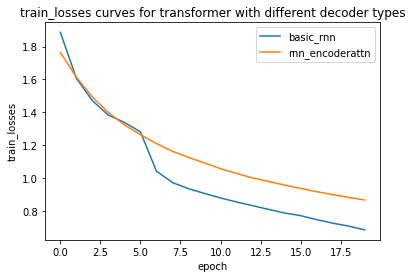

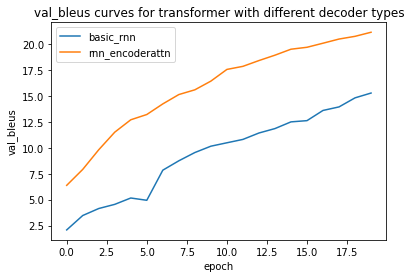

In [22]:
import matplotlib.pyplot as plt

decoders_results = json.load(open('decoders_results.json', 'r'))

for metric in ['train_losses', 'val_bleus']:
    x = range(num_epochs)
    for decoder in decoders_results:
        y = decoders_results[decoder][metric]
        plt.plot(x,y)
        plt.xlabel('epoch')
        plt.ylabel(metric)
    plt.legend(list(decoders_results.keys()))
    plt.title(f'{metric} curves for transformer with different decoder types')
    plt.show()

---
### 2 Attention visualization (12 pts)

In [23]:
# Model was trained in ~2 hours, i.e. you can expect attention maps
# to look quite 'hard' (less soft spreading) i.e. attending to some particular token in the input
nmt_t_rnn = torch.load(get_full_filepath(saved_model_path, 'rnn_encoderattn'), map_location=global_variables.device)

In [41]:
def v2t(input, source_or_target):
    if input.dim() == 1:
        output_tokens = []
        # Remove the final END_TOKEN that is appended to predictions
        for token in input:
            if token == global_variables.EOS_IDX:
                break
            else:
                output_tokens.append(token)
        if source_or_target == 'source':
            return dataset_dict['val'].source_lang_obj.vec2txt(output_tokens)
        elif source_or_target == 'target':
            return dataset_dict['val'].target_lang_obj.vec2txt(output_tokens)
        else:
            raise ValueError(f'Expected source_or_target value of "source" or "target", got {source_or_target}')

    elif input.dim() == 2:
        return [v2t(input[i]) for i in range(input.size(0))]
    raise RuntimeError(
        "Improper input to v2t with dimensions {}".format(input.size())
    )


In [47]:
for data in dataloader_dict['val']:
    preds_words, attn_wts, predictions = nmt_t_rnn.eval_step(data, return_attn=True)
    break

source_texts = data.text_vecs[:3]
label_texts = data.label_vecs[:3]

for i in range(len(label_texts)):
    print('Source:', v2t(source_texts[i], 'source'))
    print('True Translation:', v2t(label_texts[i], 'target'))
    print('Predicted Translation:', preds_words[i])
    print('\n')



Source: if i had worked hard in my youth i would be successful now .
True Translation: si j avais travaille dur dans ma jeunesse j aurais du succes maintenant .
Predicted Translation: si dur j avais tres envie de me trouver maintenant .


Source: the best thing to do is to ask an expert to repair it .
True Translation: la meilleure chose a faire est de solliciter un expert pour le reparer .
Predicted Translation: c est la meilleure pour demander de faire ca pour demander a faire .


Source: if there weren t so many taxis there would be fewer traffic accidents .
True Translation: s il n y avait pas autant de taxis il y aurait moins d accidents .
Predicted Translation: il ne serait pas si beau si le reste de la circulation .




In [ ]:
!pip install seaborn;

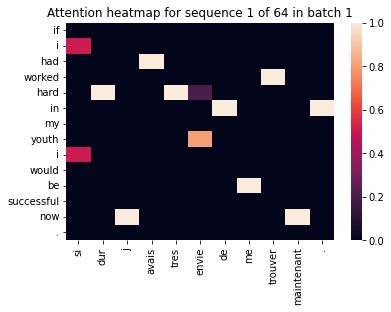

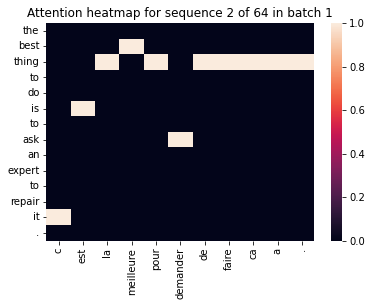

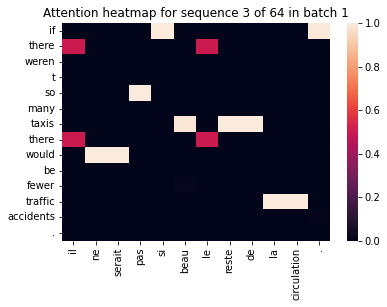

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def attention_heatmap(predictions, attn_wts, source_texts, source_lens, seq_id):
    for i, elem in enumerate(predictions[seq_id]):
        if elem == 3:
            break

    seq = predictions[seq_id][:i]
    heatmap = pd.DataFrame()

    for t, attention_matrix_t in enumerate(attn_wts):
        if t >= seq.size(0):
            break
        seq_token = v2t(seq[t].unsqueeze(0), 'target')
        attention_matrix_t = attention_matrix_t[0].detach().cpu().numpy()
        heatmap[seq_token] = attention_matrix_t[:,seq_id][:source_lens[seq_id]-1]

    y_axis_labels = v2t(source_texts[seq_id], 'source').split(' ')
    sns.heatmap(heatmap, yticklabels=y_axis_labels)
    plt.yticks(rotation=0)
    plt.title(f'Attention heatmap for sequence {seq_id+1} of {batchSize} in batch 1')
    plt.show()

source_texts = data.text_vecs
source_lens = data.text_lens

for seq_id in range(3):
    attention_heatmap(predictions, attn_wts, source_texts, source_lens, seq_id)
